In [1]:
import pandas as pd
import numpy as np
import itertools as it
import os
import io
import logging

import boto3
import sys
import json
import snowflake.connector

# Reading Data 

In [2]:
input_bucket = "hbo-ingest-datascience-content-dev"

In [3]:
logger = logging.getLogger()
logger.info(f'Loading inputs')
data_list =[]

s3 = boto3.resource('s3')
bucket = s3.Bucket(input_bucket)

for obj in bucket.objects.filter(Prefix='cost_allocation/dev/churn_metric_0906'): #churn_metric_0811
            key = obj.key
            logger.info('Loading csv file {}'.format(key))
            body = obj.get()['Body']
            print('Reading {0} features'.format(key))
            churn_metric = pd.read_csv(body, na_values = [r'\\\\N'])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


Reading cost_allocation/dev/churn_metric_0906.csv features


In [4]:
churn_metric.head()

,Unnamed: 0,genre,medal,category,churn_per_hr_person
0,0,action,Platinum,movies,-0.028358
1,1,action,Gold,series,-0.020530
2,2,action,Gold,movies,-0.027117
3,3,action,Silver,series,-0.005406
4,4,action,Silver,movies,-0.019190


In [5]:
hours_viewed = pd.read_csv('content_slate_prediction.csv')

In [6]:
len(hours_viewed)

726

In [7]:
hours_viewed = hours_viewed.reset_index()

In [8]:
hours_viewed = hours_viewed[['title_name', 'season_number', 'offering_start_date', 'prediction', 'genre', 
                             'medal', 'content_category', 'asset_run_time_hours', 'index']]

In [9]:
hours_viewed.rename(columns = {'content_category':'category', 'index':'name_number'}, inplace = True)

In [10]:
hours_viewed.loc[(hours_viewed['genre'].isin(['action', 'other'])) & (hours_viewed['medal']=='Platinum')
                &(hours_viewed['category']=='series'), 'genre'] = 'comedy'

In [11]:
hours_viewed = hours_viewed.merge(churn_metric[['genre','medal','category', 'churn_per_hr_person']], on = ['genre','medal','category'],
                                 how = 'left')

In [12]:
len(hours_viewed)

726

In [13]:
hours_viewed['change_in_churn_60d_prediction'] = hours_viewed['prediction'] * hours_viewed['churn_per_hr_person']

In [14]:
hours_viewed_thresh = hours_viewed

# Allocate the 60-Day Churn to monthly

In [15]:
ever_green_titles = pd.read_csv('final_evergreen_title_list.csv') #final_evergreen_title_list.csv # ever_green_titles.csv

In [16]:
len(ever_green_titles.title_id.unique())

11

In [17]:
ever_green_title_name = ever_green_titles.title_name.unique()
norm_title_name = hours_viewed_thresh[~hours_viewed_thresh['title_name'].isin(ever_green_title_name)].title_name.unique()

In [18]:
ever_green_title_name

array(['The Sopranos', 'Curb Your Enthusiasm', 'Sex and the City',
       'Game of Thrones', 'American Pie', 'War Dogs',
       'Pretty Little Liars', 'The Big Bang Theory', 'Friends',
       'Annabelle Comes Home', 'X-Men: Dark Phoenix'], dtype=object)

### 1. Normal Titles

In [19]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [20]:
from scipy.optimize import curve_fit

In [41]:
historical_weekly_hours_viewed = pd.read_csv('historical_weekly_hours_viewed.csv')

In [42]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

In [43]:
train_data = historical_weekly_hours_viewed.copy()
##### TRAIN FOR MOVIE ############
x1 = (train_data[train_data['content_category'] == 'movies']['days_on_hbo_max'])
y1 = train_data[train_data['content_category'] == 'movies']['target']
popt1, pcov1 = curve_fit(func, x1, y1)

##### TRAIN FOR SERIES ############
x2 = (train_data[train_data['content_category'] == 'series']['days_on_hbo_max'])
y2 = train_data[train_data['content_category'] == 'series']['target']
popt2, pcov2 = curve_fit(func, x2, y2)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [44]:
x = pd.Series(np.arange(0,150,1))
y1 = func(x, *popt1)
y2 = func(x, *popt2)

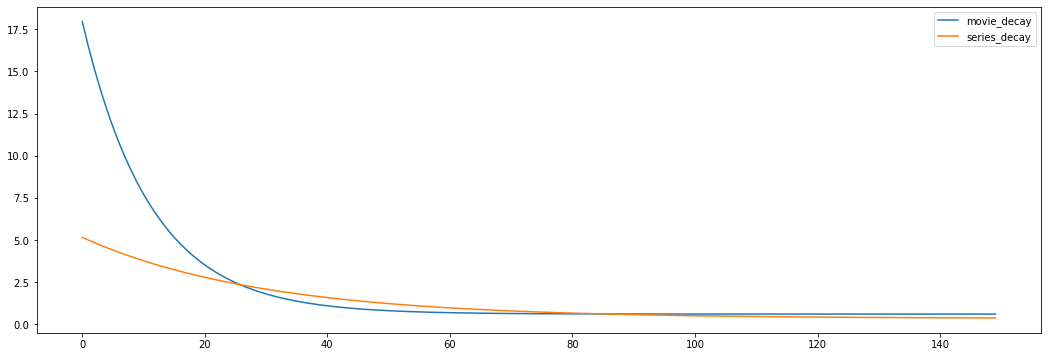

In [45]:
fig, ax = plt.subplots(figsize=(18, 6))
plt.plot(x, y1, label = 'movie_decay')
plt.plot(x, y2, label = 'series_decay')

plt.legend()
plt.show()

In [46]:
dt_df_movie = pd.DataFrame({'days_on_hbo_max': x,
                           'factor': y1,
                           'content_category': 'movies'})
dt_df_series = pd.DataFrame({'days_on_hbo_max': x,
                           'factor': y2,
                           'content_category': 'series'})
dt_df = pd.concat([dt_df_movie, dt_df_series], axis = 0)
dt_df.rename(columns = {'content_category':'category'}, inplace = True)

In [47]:
day_60_cum_sum = dt_df[dt_df['days_on_hbo_max']<60].groupby(['category']).factor.sum().reset_index()

In [59]:
hours_viewed_decay_norm = hours_viewed_thresh

hours_viewed_decay_norm = hours_viewed_decay_norm.merge(dt_df, on = ['category'])\
                                                 .merge(day_60_cum_sum.rename(columns = {'factor':'cum_sum'}), on = ['category'])

hours_viewed_decay_norm['change_in_churn_prediction'] = hours_viewed_decay_norm['change_in_churn_60d_prediction']/hours_viewed_decay_norm['cum_sum']*hours_viewed_decay_norm['factor']*hours_viewed_decay_norm['asset_run_time_hours']

hours_viewed_decay_norm['request_date'] = pd.to_datetime(hours_viewed_decay_norm['offering_start_date']) \
                                        + pd.to_timedelta(hours_viewed_decay_norm['days_on_hbo_max'], unit='D')

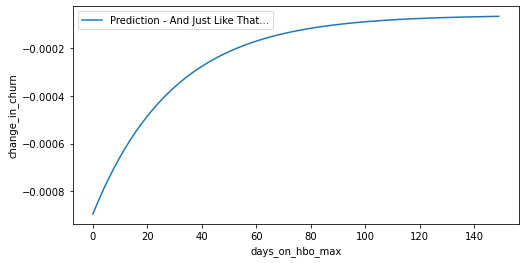

In [62]:
fig, ax = plt.subplots(figsize=(8, 4))
test = hours_viewed_decay_norm
plot_df = test[test['title_name'].str.contains('EUPHORIA S3')]
plt.plot(plot_df['days_on_hbo_max'], plot_df['change_in_churn_prediction'], label='Prediction - And Just Like That...')

ax.set_xlabel('days_on_hbo_max')
ax.set_ylabel('change_in_churn')
ax.legend()

plt.show()

### 2. Evergreen Titles

#### 2.2 Keep the retention value all the way along

In [63]:
# dt_df = pd.DataFrame()
# dt_df['days_on_hbo_max'] = [i for i in range(0, 365*3, 1)]
# dt_df['key'] = 1

# hours_viewed_decay_evergreen = hours_viewed_thresh[hours_viewed_thresh['title_id'].isin(ever_green_title_id)]
# hours_viewed_decay_evergreen['key'] = 1

# hours_viewed_decay_evergreen = hours_viewed_decay_evergreen.merge(dt_df, on = ['key']).drop(['key'], axis = 1)

# hours_viewed_decay_evergreen['change_in_churn'] = hours_viewed_decay_evergreen['change_in_churn_60d']/60*hours_viewed_decay_evergreen['asset_run_time_hours']
# hours_viewed_decay_evergreen['change_in_churn_prediction'] = hours_viewed_decay_evergreen['change_in_churn_60d_prediction']/60*hours_viewed_decay_evergreen['asset_run_time_hours']

# hours_viewed_decay_evergreen['request_date'] = pd.to_datetime(hours_viewed_decay_evergreen['offering_start_date']) \
#                                         + pd.to_timedelta(hours_viewed_decay_evergreen['days_on_hbo_max'], unit='D')

# hours_viewed_decay_evergreen = hours_viewed_decay_evergreen[hours_viewed_decay_evergreen['request_date'] <= '2023-03-01']


In [64]:
# fig, ax = plt.subplots(figsize=(8, 4))
# test = hours_viewed_decay_evergreen


# for i in range(1,2,1):
#     plot_df = test[(test['title_name'] == 'Friends') &(test['season_number'] == i)]
#     plt.plot(plot_df['days_on_hbo_max'], plot_df['change_in_churn'], label= 'Actual - Friends S' + str(i))
#     plt.plot(plot_df['days_on_hbo_max'], plot_df['change_in_churn_prediction'], label= 'Prediction - Friends S' + str(i))

# ax.set_xlabel('days_on_hbo_max')
# ax.set_ylabel('change_in_churn')
# ax.legend()

# plt.show()

## UNION ALL THE DFs

In [65]:
# data = pd.concat([hours_viewed_decay_norm[['title_name', 'title_id', 'season_number', 'request_date',  'days_on_hbo_max', 'change_in_churn', 'change_in_churn_prediction']],
#                 hours_viewed_decay_evergreen[['title_name', 'title_id', 'season_number', 'request_date',  'days_on_hbo_max', 'change_in_churn', 'change_in_churn_prediction']] ],
#                 axis = 0)
data = hours_viewed_decay_norm

In [66]:
data['date_month'] = data['request_date'].dt.to_period('M')

In [67]:
data.head()

,title_name,season_number,offering_start_date,prediction,genre,medal,category,asset_run_time_hours,name_number,churn_per_hr_person,change_in_churn_60d_prediction,days_on_hbo_max,factor,cum_sum,change_in_churn_prediction,request_date,date_month
0,AFTER THE BITE,NaN,2023-07-01,0.03266,other,Silver,movies,1.5,0,-0.038234,-0.001249,0,17.958630,239.07981,-0.000141,2023-07-01,2023-07
1,AFTER THE BITE,NaN,2023-07-01,0.03266,other,Silver,movies,1.5,0,-0.038234,-0.001249,1,16.478661,239.07981,-0.000129,2023-07-02,2023-07
2,AFTER THE BITE,NaN,2023-07-01,0.03266,other,Silver,movies,1.5,0,-0.038234,-0.001249,2,15.124960,239.07981,-0.000118,2023-07-03,2023-07
3,AFTER THE BITE,NaN,2023-07-01,0.03266,other,Silver,movies,1.5,0,-0.038234,-0.001249,3,13.886754,239.07981,-0.000109,2023-07-04,2023-07
4,AFTER THE BITE,NaN,2023-07-01,0.03266,other,Silver,movies,1.5,0,-0.038234,-0.001249,4,12.754190,239.07981,-0.000100,2023-07-05,2023-07


#### Write to S3/SF

In [72]:
import boto3
import io

def to_s3(filename, output_bucket, content):
    client = boto3.client('s3')
    client.put_object(Bucket=output_bucket, Key=filename, Body=content)
    
output_bucket = 'hbo-outbound-datascience-content-dev'
s3 = boto3.resource('s3')
bucket = s3.Bucket(output_bucket)

def write_to_sf(df, file_name):
    csv_buffer = io.StringIO()
    df.to_csv(csv_buffer, index = False)
    content = csv_buffer.getvalue()
    filename = 'title_hours_viewed_retention/{}.csv'.format(file_name)
    to_s3(filename, output_bucket, content)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [73]:
# data.to_csv('daily_monthly_retention_value.csv')

In [74]:
filename = 'content_slate_daily_monthly_retention_value_'+pd.Timestamp.today().strftime('%Y-%m-%d') 

In [75]:
write_to_sf(data,  filename)

In [76]:
len(data)

108900

In [77]:
output_bucket+'/title_hours_viewed_retention/{}.csv'.format(filename)

'hbo-outbound-datascience-content-dev/title_hours_viewed_retention/content_slate_daily_monthly_retention_value_2023-09-26.csv'

In [89]:
data.head()

,title_name,season_number,offering_start_date,prediction,genre,medal,category,asset_run_time_hours,name_number,churn_per_hr_person,change_in_churn_60d_prediction,days_on_hbo_max,factor,cum_sum,change_in_churn_prediction,request_date,date_month,month_number,month_name
0,AFTER THE BITE,NaN,2023-07-01,0.03266,other,Silver,movies,1.5,0,-0.038234,-0.001249,0,17.958630,239.07981,-0.000141,2023-07-01,2023-07,0.0,M1
1,AFTER THE BITE,NaN,2023-07-01,0.03266,other,Silver,movies,1.5,0,-0.038234,-0.001249,1,16.478661,239.07981,-0.000129,2023-07-02,2023-07,0.0,M1
2,AFTER THE BITE,NaN,2023-07-01,0.03266,other,Silver,movies,1.5,0,-0.038234,-0.001249,2,15.124960,239.07981,-0.000118,2023-07-03,2023-07,0.0,M1
3,AFTER THE BITE,NaN,2023-07-01,0.03266,other,Silver,movies,1.5,0,-0.038234,-0.001249,3,13.886754,239.07981,-0.000109,2023-07-04,2023-07,0.0,M1
4,AFTER THE BITE,NaN,2023-07-01,0.03266,other,Silver,movies,1.5,0,-0.038234,-0.001249,4,12.754190,239.07981,-0.000100,2023-07-05,2023-07,0.0,M1


In [83]:
data['month_number'] = (data['days_on_hbo_max']/30).apply(np.floor)

In [88]:
data['month_name'] = 'M' + (data['month_number']+1).astype(int).astype(str)

In [93]:
pivot_table = pd.pivot_table(data, values='change_in_churn_prediction', 
                             index=['title_name', 'name_number', 'offering_start_date', 'genre', 'medal', 'category'],
                           columns=['month_name'], aggfunc="sum", fill_value=np.NaN)

In [91]:
len(pivot_table)

726

In [94]:
pivot_table.to_csv('MoM Content Slate Retention Value.csv')

In [279]:
# pivot_table = pd.pivot_table(data, values='change_in_churn_prediction', 
#                              index=['title_name', 'name_number', 'offering_start_date'],
#                            columns=['date_month'], aggfunc="sum", fill_value=np.NaN)

In [280]:
len(pivot_table)

726

In [281]:
pivot_table.to_csv('MoM Content Slate Retention Value.csv')